# OOP for ML Pipeline: CustomTransformer for Binning

This notebook is another endeavor to develop modularized machine learning pipeline that is easy to update and maintain. 

A CustomTransformer class is created. This transformer can handle common preprocessing steps such as imputing, scaling, and OneHotEncoding. More interestingly, it can also  bin numeric or categorical features of user's choice in a way that optimizes the relationship between the feature and the target variable utilizing the[optbinning package](http://gnpalencia.org/optbinning/). 

This CustomTransformer can then be called in another CustomModel class which can first preproces data and then train any models that adhere to a scikit-learn-like API pattern. Pls see the demo at the end where this is tested for Xgboost, RandomForest and LightGBM models. 

In [121]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from optbinning import BinningProcess 
from optbinning import OptimalBinning

# auto binning

Below is the first iteration. Leverage autobinning by `optbinning` package so we can fit and transform a dataframe with both bin_features and num_features to scale. 

In [122]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, bin_features=None, num_features=None, binning_settings=None):
        self.bin_features = bin_features
        self.num_features = num_features
        self.binning_settings = binning_settings

    def fit(self, X, y=None):
        if self.bin_features:
            self.binning_process = {}
            for feature_name in self.bin_features:
                binning_process = BinningProcess(variable_names=[feature_name])
                binning_process.fit(X[feature_name].to_frame(), y)
                self.binning_process[feature_name] = binning_process

        if self.num_features:
            self.scaler = StandardScaler()
            self.scaler.fit(X[self.num_features])

        return self

    def transform(self, X):
        X_transformed = X.copy()

        if self.bin_features:
            for feature_name in self.bin_features:
                binned_data = self.binning_process[feature_name].transform(X[feature_name].to_frame())
                X_transformed[feature_name] = binned_data

        if self.num_features:
            scaled_data = self.scaler.transform(X[self.num_features])
            scaled_df = pd.DataFrame(scaled_data, columns=self.num_features, index=X.index)
            X_transformed[self.num_features] = scaled_df

        return X_transformed 

    def fit_transform(self, X, y=None):
        self.fit(X,y)
        return self.transform(X)   


In [123]:
n_feature = 5
n_inform = 5
n_redundant = 0
n_bin = 3
X, y = make_classification(n_samples = 1000, n_features = n_feature, n_informative = n_inform, n_redundant=n_redundant)

bin_features = [f'bin_{i+1}' for i in range(n_bin)]
num_features = [f'num_{n_bin+i+1}' for i in range(n_feature-n_bin)]
X = pd.DataFrame(X, columns = bin_features + num_features)


In [124]:
custom_transformer = CustomTransformer(
    bin_features=bin_features,
    num_features=num_features,
)

In [125]:
custom_transformer.fit(X,y)

CustomTransformer(bin_features=['bin_1', 'bin_2', 'bin_3'],
                  num_features=['num_4', 'num_5'])

In [126]:
X_transformed = custom_transformer.transform(X.copy())

In [127]:
X.head()

,bin_1,bin_2,bin_3,num_4,num_5
0,1.716857,-3.041167,-1.312917,0.428118,-0.379046
1,-1.201785,-0.976944,-0.697437,0.733114,-3.223350
2,0.421686,0.829949,-0.938834,1.286938,-0.970991
3,-0.390698,1.774233,0.284909,3.550472,-1.244213
4,1.638622,-2.204433,-1.262744,0.387052,-1.596152


In [128]:
X_transformed.head()

,bin_1,bin_2,bin_3,num_4,num_5
0,0.151641,0.573346,0.130453,-0.024514,0.452383
1,-0.570545,-0.624154,0.130453,0.182645,-1.717071
2,0.151641,0.230016,0.130453,0.558813,0.000885
3,-0.149036,0.230016,0.023530,2.096249,-0.207511
4,0.151641,0.160930,0.130453,-0.052407,-0.475948


In [129]:
custom_transformer.fit_transform(X,y)

,bin_1,bin_2,bin_3,num_4,num_5
0,0.151641,0.573346,0.130453,-0.024514,0.452383
1,-0.570545,-0.624154,0.130453,0.182645,-1.717071
2,0.151641,0.230016,0.130453,0.558813,0.000885
3,-0.149036,0.230016,0.023530,2.096249,-0.207511
4,0.151641,0.160930,0.130453,-0.052407,-0.475948
...,...,...,...,...,...
995,0.197826,0.160930,0.582605,-0.332290,0.300679
996,0.151641,0.230016,0.130453,-1.848297,-0.823861
997,0.151641,0.016807,0.130453,-0.615837,-0.198200
998,-0.149036,0.573346,0.023530,0.051504,0.771825


In [130]:
custom_transformer.binning_process.get('bin_1')

BinningProcess(variable_names=['bin_1'])

# next step: Add customized settings

We should be able to define special code and other configurations for each bin_feature. Below is a demo of how that can be done using `OptimalBinning`. 

## Toy Example

In [131]:
# Example data
data = pd.DataFrame({'feature1': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]})
target = [1,0,0,0,0,1,1,0,1,1]

# Define predefined split points for feature1
predefined_splits = [3, 8]
special_codes = [999,9999]

# Create an OptimalBinning instance with specific configurations
optb = OptimalBinning(name='feature1', 
                      user_splits=predefined_splits,
                      special_codes=special_codes,
                      dtype='numerical',
                      monotonic_trend='auto'
                      )

# Fit and transform the binning model to your data
optb.fit(data['feature1'], target) 
binning_table = optb.binning_table
table_built = binning_table.build()
binned_data = optb.transform(data['feature1'])

# Print the binned data
print("Binning table: \n", table_built)
print("Binned data: \n", binned_data)


Binning table: 
                  Bin  Count  Count (%)  Non-event  Event  Event rate  \
0       (-inf, 3.00)      2        0.2          1      1    0.500000   
1       [3.00, 8.00)      5        0.5          3      2    0.400000   
2        [8.00, inf)      3        0.3          1      2    0.666667   
3            Special      0        0.0          0      0    0.000000   
4            Missing      0        0.0          0      0    0.000000   
Totals                   10        1.0          5      5    0.500000   

             WoE        IV        JS  
0            0.0  0.000000  0.000000  
1       0.405465  0.081093  0.010068  
2      -0.693147  0.138629  0.016990  
3            0.0  0.000000  0.000000  
4            0.0  0.000000  0.000000  
Totals            0.219722  0.027058  
Binned data: 
 [ 0.          0.          0.40546511  0.40546511  0.40546511  0.40546511
  0.40546511 -0.69314718 -0.69314718 -0.69314718]


## Utilized in our demo data

Similarly, we can prepare specific configurations for each feature and pass that to our custom class.

In [132]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, bin_features=None, num_features=None, binning_settings=None):
        self.bin_features = bin_features
        self.num_features = num_features
        self.binning_settings = binning_settings
        self.binning_models = {}
        self.scaler = None

    def fit(self, X, y=None):
        if self.bin_features:
            for feature_name in self.bin_features:
                bin_cfg = self.binning_settings[feature_name]
                print(f'configuration for {feature_name}:', bin_cfg)
                binning_model = OptimalBinning(name=feature_name,
                                               special_codes = bin_cfg.get('special_codes', None),
                                               user_splits = bin_cfg.get('user_splits', None),
                                               dtype = bin_cfg.get('dtype', 'numerical'),
                                               monotonic_trend = bin_cfg.get('monotonic_trend', None))
                binning_model.fit(X[feature_name], y)
                self.binning_models[feature_name] = binning_model

        if self.num_features:
            self.scaler = StandardScaler()
            self.scaler.fit(X[self.num_features])

        return self

    def transform(self, X):
        X_transformed = X.copy()

        if self.bin_features:
            for feature_name in self.bin_features:
                binning_model = self.binning_models.get(feature_name)
                if binning_model:
                    X_transformed[feature_name] = binning_model.transform(X[feature_name])

        if self.num_features:
            scaled_data = self.scaler.transform(X[self.num_features])
            scaled_df = pd.DataFrame(scaled_data, columns=self.num_features, index=X.index)
            X_transformed[self.num_features] = scaled_df

        return X_transformed


In [133]:
binning_settings = {
    'bin_1': {
            'dtype': 'numerical',
            'monotonic_trend': 'auto',
            'user_splits': [-0.5, 0, 0.5],
            'special_codes': [99,999]
              }
   ,'bin_2': {'dtype': 'numerical',
              'monotonic_trend': 'ascending',
              'user_splits': None,
              }
   ,'bin_3': {}
}

In [134]:
custom_transformer = CustomTransformer(
    bin_features=bin_features,
    num_features=num_features,
    binning_settings=binning_settings    
)

In [135]:
custom_transformer.fit(X,y)

configuration for bin_1: {'dtype': 'numerical', 'monotonic_trend': 'auto', 'user_splits': [-0.5, 0, 0.5], 'special_codes': [99, 999]}
configuration for bin_2: {'dtype': 'numerical', 'monotonic_trend': 'ascending', 'user_splits': None}
configuration for bin_3: {}


CustomTransformer(bin_features=['bin_1', 'bin_2', 'bin_3'],
                  binning_settings={'bin_1': {'dtype': 'numerical',
                                              'monotonic_trend': 'auto',
                                              'special_codes': [99, 999],
                                              'user_splits': [-0.5, 0, 0.5]},
                                    'bin_2': {'dtype': 'numerical',
                                              'monotonic_trend': 'ascending',
                                              'user_splits': None},
                                    'bin_3': {}},
                  num_features=['num_4', 'num_5'])

In [136]:
X_transformed = custom_transformer.transform(X.copy())

In [137]:
X_transformed.head()

,bin_1,bin_2,bin_3,num_4,num_5
0,0.146093,0.573346,-0.074108,-0.024514,0.452383
1,-0.115436,-0.137508,0.777705,0.182645,-1.717071
2,0.017700,-0.137508,0.377294,0.558813,0.000885
3,-0.115436,-0.137508,0.023530,2.096249,-0.207511
4,0.146093,0.160930,-0.331357,-0.052407,-0.475948


# Add categorical variables

Next step, let's add a bit more complexity, let's add categorical variables.

To bin a categorical variable doesn't change the shape of transformed data and is relatively simple (see bin_3). Let's also treat one of the categorial feature (see cat_5) the traditional way, OneHotEncoding, which will change the shape and post a small challenge to ensure all columns in the transformed data should have meaningful name.

### Firs iteration

Wrap what we do for num_features into a num_transformer. The same will then be done for cat_features. 

use a num_transformer/cat_transformer wrapper have several benefits
* multiple steps may be taken for each data type, wrapping them together for easy update and maintainance
* the same function may be utilized to treat num and cat features, say SimpleImputer()

In [138]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, bin_features=None, num_features=None, binning_settings=None):
        self.bin_features = bin_features
        self.num_features = num_features
        self.binning_settings = binning_settings
        self.binning_models = {}
        self.binning_tables = {}
        self.num_transformer = None

    def fit(self, X, y=None):
        if self.bin_features:
            for feature_name in self.bin_features:
                bin_cfg = self.binning_settings[feature_name]
                print(f'configuration for {feature_name}:', bin_cfg)
                binning_model = OptimalBinning(name=feature_name,
                                               special_codes = bin_cfg.get('special_codes', None),
                                               user_splits = bin_cfg.get('user_splits', None),
                                               dtype = bin_cfg.get('dtype', 'numerical'),
                                               monotonic_trend = bin_cfg.get('monotonic_trend', None))
                binning_model.fit(X[feature_name], y)
                self.binning_models[feature_name] = binning_model

        if self.num_features:
            self.num_transformer = Pipeline(steps=[
                ('scaler', StandardScaler())
            ])
            self.num_transformer.fit(X[self.num_features])
        
        return self

    def transform(self, X):
        X_transformed = X.copy()

        if self.bin_features:
            for feature_name in self.bin_features:
                binning_model = self.binning_models.get(feature_name)
                if binning_model:
                    X_transformed[feature_name] = binning_model.transform(X[feature_name])

        if self.num_features:
            transformed_num_data = self.num_transformer.transform(X[self.num_features])
            # transformed_num_data = pd.DataFrame(transformed_num_data, columns=self.num_features, index=X.index)
            X_transformed[self.num_features] = transformed_num_data

        return X_transformed

In [139]:
custom_transformer = CustomTransformer(
    bin_features=bin_features,
    num_features=num_features,
    binning_settings=binning_settings    
)

In [145]:
custom_transformer.fit(X,y)

configuration for bin_1: {'dtype': 'numerical', 'monotonic_trend': 'auto', 'user_splits': [-0.5, 0, 0.5], 'special_codes': [99, 999]}
configuration for bin_2: {'dtype': 'numerical', 'monotonic_trend': 'ascending', 'user_splits': None}
configuration for bin_3: {}


CustomTransformer(bin_features=['bin_1', 'bin_2', 'bin_3'],
                  binning_settings={'bin_1': {'dtype': 'numerical',
                                              'monotonic_trend': 'auto',
                                              'special_codes': [99, 999],
                                              'user_splits': [-0.5, 0, 0.5]},
                                    'bin_2': {'dtype': 'numerical',
                                              'monotonic_trend': 'ascending',
                                              'user_splits': None},
                                    'bin_3': {}},
                  num_features=['num_4', 'num_5'])

In [146]:
transformed_X = custom_transformer.transform(X.copy())

In [147]:
transformed_X

,bin_1,bin_2,bin_3,num_4,num_5
0,0.146093,0.573346,-0.074108,-0.024514,0.452383
1,-0.115436,-0.137508,0.777705,0.182645,-1.717071
2,0.017700,-0.137508,0.377294,0.558813,0.000885
3,-0.115436,-0.137508,0.023530,2.096249,-0.207511
4,0.146093,0.160930,-0.331357,-0.052407,-0.475948
...,...,...,...,...,...
995,0.146093,0.160930,1.152680,-0.332290,0.300679
996,0.146093,-0.137508,-0.074108,-1.848297,-0.823861
997,0.146093,0.016807,-0.331357,-0.615837,-0.198200
998,-0.115436,0.573346,0.023530,0.051504,0.771825


### Second Iteration. Categorical Features to Bin

This step is effortless: Just update the binning_settings, then we are done. :)

But to add a little bit of fun, I added binning_tables attribute to our class which will help us to see more details on how each features are binned and create visuals based on it. 

In [148]:
X_ = X.copy()
percentiles = [0, 0.1, 0.5, 0.9, 1]
labels = ['bottom', 'lower-mid', 'upper-mid', 'top']
labels_ = ['a', 'b', 'c', 'd']
X_['bin_3'] = pd.qcut(X_['bin_3'], q=percentiles, labels=labels)


In [149]:
binning_settings['bin_3'] = {'dtype': 'categorical',
                             'monotonic': 'auto',
                             'user_splits': None}

In [150]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, bin_features=None, num_features=None, binning_settings=None):
        self.bin_features = bin_features
        self.num_features = num_features
        self.binning_settings = binning_settings
        self.binning_models = {}
        self.binning_tables = {}
        self.num_transformer = None

    def fit(self, X, y=None):
        if self.bin_features:
            for feature_name in self.bin_features:
                bin_cfg = self.binning_settings[feature_name]
                print(f'configuration for {feature_name}:', bin_cfg)
                binning_model = OptimalBinning(name=feature_name,
                                               special_codes = bin_cfg.get('special_codes', None),
                                               user_splits = bin_cfg.get('user_splits', None),
                                               dtype = bin_cfg.get('dtype', 'numerical'),
                                               monotonic_trend = bin_cfg.get('monotonic_trend', None))
                binning_model.fit(X[feature_name], y)
                self.binning_models[feature_name] = binning_model
                self.binning_tables[feature_name] = binning_model.binning_table

        if self.num_features:
            self.num_transformer = Pipeline(steps=[
                ('scaler', StandardScaler())
            ])
            # self.scaler = StandardScaler()
            self.num_transformer.fit(X[self.num_features])

        return self

    def transform(self, X):
        X_transformed = pd.DataFrame()
        X_transformed.index = X.index

        if self.bin_features:
            for feature_name in self.bin_features:
                binning_model = self.binning_models.get(feature_name)
                if binning_model:
                    X_transformed[feature_name] = binning_model.transform(X[feature_name])

        if self.num_features:
            transformed_num_data = self.num_transformer.transform(X[self.num_features])
            X_transformed[self.num_features] = transformed_num_data

        return X_transformed
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

In [151]:
custom_transformer = CustomTransformer(
    bin_features=bin_features,
    num_features=num_features,
    binning_settings=binning_settings 
)

In [152]:
X_transformed = custom_transformer.fit_transform(X_, y)

configuration for bin_1: {'dtype': 'numerical', 'monotonic_trend': 'auto', 'user_splits': [-0.5, 0, 0.5], 'special_codes': [99, 999]}
configuration for bin_2: {'dtype': 'numerical', 'monotonic_trend': 'ascending', 'user_splits': None}
configuration for bin_3: {'dtype': 'categorical', 'monotonic': 'auto', 'user_splits': None}


In [153]:
custom_transformer.binning_tables['bin_3'].build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[bottom],100,0.1,66,34,0.340,0.663294,0.042451,0.005211
1,[lower-mid],400,0.4,230,170,0.425,0.302281,0.036274,0.004517
2,[upper-mid],400,0.4,190,210,0.525,-0.100083,0.004003,0.000500
3,[top],100,0.1,14,86,0.860,-1.81529,0.261402,0.028818
4,Special,0,0.0,0,0,0.000,0.0,0.000000,0.000000
5,Missing,0,0.0,0,0,0.000,0.0,0.000000,0.000000
Totals,,1000,1.0,500,500,0.500,,0.344130,0.039047


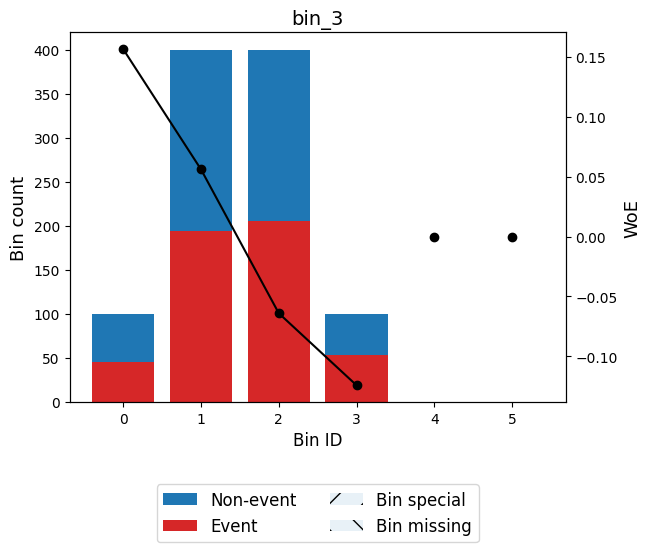

In [114]:
custom_transformer.binning_tables['bin_3'].plot()

In [154]:
X_transformed.head()

,bin_1,bin_2,bin_3,num_4,num_5
0,0.146093,0.573346,0.302281,-0.024514,0.452383
1,-0.115436,-0.137508,-0.100083,0.182645,-1.717071
2,0.017700,-0.137508,0.302281,0.558813,0.000885
3,-0.115436,-0.137508,-0.100083,2.096249,-0.207511
4,0.146093,0.160930,0.302281,-0.052407,-0.475948


## Iteration 3: Add Categorical Features

In [155]:
# update data and settings
percentiles = [0, 0.1, 0.5, 0.9, 1]
labels = ['D', 'C', 'B', 'A']
X2 = X_.copy()
X2['cat_5'] = pd.qcut(X2['num_5'], q=percentiles, labels=labels)
X2.drop('num_5', axis = 1, inplace = True)

num_features=['num_4']
cat_features=['cat_5']

In [156]:
class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, bin_features=None, num_features=None, 
                 cat_features=None, binning_settings=None):
        self.bin_features = bin_features
        self.num_features = num_features
        self.cat_features = cat_features
        self.binning_settings = binning_settings
        self.binning_models = {}
        self.binning_tables = {}
        self.num_transformer = None
        self.cat_transformer = None
        self.transformed_cat_cols = []
    
    @staticmethod
    def scan_and_clean(X, missing_pct_threshold = 0.5, verbose=True):
        """This static method can be used to do basic cleaning and scanning before fit and transform
        """
        missing_pct = (X.isnull().sum() / len(X)) 
        high_missing_features = missing_pct[missing_pct>missing_pct_threshold]
        if verbose:
            print(f'These features have missing higher than the threshold {missing_pct_threshold}:', high_missing_features)
        return X
        
    def fit(self, X, y=None):
        X_ = CustomTransformer.scan_and_clean(X.copy(), verbose=False)
        if self.bin_features:
            for feature_name in self.bin_features:
                bin_cfg = self.binning_settings[feature_name]
                print(f'configuration for {feature_name}:', bin_cfg)
                binning_model = OptimalBinning(name=feature_name,
                                               special_codes = bin_cfg.get('special_codes', None),
                                               user_splits = bin_cfg.get('user_splits', None),
                                               dtype = bin_cfg.get('dtype', 'numerical'),
                                               monotonic_trend = bin_cfg.get('monotonic_trend', None))
                binning_model.fit(X_[feature_name], y)
                self.binning_models[feature_name] = binning_model
                self.binning_tables[feature_name] = binning_model.binning_table
        
        if self.num_features:
            self.num_transformer = Pipeline(steps=[
                ('scaler', StandardScaler()),
                ('imputer', SimpleImputer(strategy = 'median'))
            ])
            self.num_transformer.fit(X_[self.num_features])
        
        if self.cat_features:
            self.cat_transformer = Pipeline(steps = [
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(handle_unknown='ignore'))
            ])
            self.cat_transformer.fit(X_[self.cat_features])
        
        return self
    
    def get_transformed_cat_cols(self):
        cat_cols = []
        cats = self.cat_features
        cat_values = self.cat_transformer['encoder'].categories_
        for cat, values in zip(cats, cat_values):
            cat_cols += [f'{cat}_{value}' for value in values]
        
        return cat_cols
        
    
    def transform(self, X):
        X_ = CustomTransformer.scan_and_clean(X.copy(),verbose=True)
        X_transformed = pd.DataFrame()
        
        if self.bin_features:
            for feature_name in self.bin_features:
                binning_model = self.binning_models.get(feature_name, None)
                X_transformed[feature_name] = binning_model.transform(X_[feature_name])
        
        if self.num_features:
            transformed_num_data = self.num_transformer.transform(X_[self.num_features])
            X_transformed[self.num_features] = transformed_num_data
        
        if self.cat_features:
            transformed_cat_data = self.cat_transformer.transform(X_[self.cat_features]).toarray()
            self.transformed_cat_cols = self.get_transformed_cat_cols()
            transformed_cat_df = pd.DataFrame(transformed_cat_data,
                                            columns = self.transformed_cat_cols)
        
        X_transformed = pd.concat([X_transformed,transformed_cat_df], axis=1)
        X_transformed.index = X_.index
    
        return X_transformed
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X)

In [157]:
custom_transformer = CustomTransformer(
    bin_features=bin_features,
    num_features=num_features,
    cat_features=cat_features,
    binning_settings=binning_settings 
)

In [158]:
X_transformed = custom_transformer.fit_transform(X2,y)

configuration for bin_1: {'dtype': 'numerical', 'monotonic_trend': 'auto', 'user_splits': [-0.5, 0, 0.5], 'special_codes': [99, 999]}
configuration for bin_2: {'dtype': 'numerical', 'monotonic_trend': 'ascending', 'user_splits': None}
configuration for bin_3: {'dtype': 'categorical', 'monotonic': 'auto', 'user_splits': None}
These features have missing higher than the threshold 0.5: Series([], dtype: float64)


In [159]:
X_transformed.head()

,bin_1,bin_2,bin_3,num_4,cat_5_A,cat_5_B,cat_5_C,cat_5_D
0,0.146093,0.573346,0.302281,-0.024514,0.0,1.0,0.0,0.0
1,-0.115436,-0.137508,-0.100083,0.182645,0.0,0.0,0.0,1.0
2,0.017700,-0.137508,0.302281,0.558813,0.0,0.0,1.0,0.0
3,-0.115436,-0.137508,-0.100083,2.096249,0.0,0.0,1.0,0.0
4,0.146093,0.160930,0.302281,-0.052407,0.0,0.0,1.0,0.0


# Putting it together: Combining in a ModelPipeline

We can create a ModelPipeline that preprocess the data first, and then make prediction, and maybe even offer model explanations. 

In [36]:
class ModelPipeline(BaseEstimator):

    def __init__(self, custom_transformer=None, model=None):
        self.custom_transformer = custom_transformer
        self.model = model

    def fit(self, X, y=None):
        X_train_transformed = self.custom_transformer.fit_transform(X, y)
        self.model.fit(X_train_transformed, y)
    
    def predict_proba(self,X):
        X_new_transformed = self.custom_transformer.transform(X)
        return self.model.predict_proba(X_new_transformed)

Now let's utilized the custom model. We can call any smodels that adhere to a scikit-learn-like API pattern. 

In [37]:
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb

model_pipeline = ModelPipeline(
    custom_transformer=CustomTransformer(
                        bin_features=bin_features,
                        num_features=num_features,
                        cat_features=cat_features,
                        binning_settings=binning_settings 
                    ),
    # try with any sklearn style models, for example:
    model = xgb.XGBClassifier()
    # model = RandomForestClassifier()
    # model = lgb.LGBMClassifier()
)

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size = 0.2, random_state = 42)

In [39]:
model_pipeline.fit(X_train, y_train)

configuration for bin_1: {'dtype': 'numerical', 'monotonic_trend': 'auto', 'user_splits': [-0.5, 0, 0.5], 'special_codes': [99, 999]}
configuration for bin_2: {'dtype': 'numerical', 'monotonic_trend': 'ascending', 'user_splits': None}
configuration for bin_3: {'dtype': 'categorical', 'monotonic': 'auto', 'user_splits': None}


In [40]:
from sklearn.metrics import roc_auc_score
y_prob = model_pipeline.predict_proba(X_test)
auc = roc_auc_score(y_test, y_prob[:,1])
print('auc:', auc)

auc: 0.851366229606646
